# Metodos supervisados
Autor: **Jose Romualdo Villalobos Perez**

Id: 000294087


En este notebook se va a poner en practica varios algoritmos de machine learning supervisados usando R

## Preparando los datos

### Cargando los datos
En esta secciòn cargaremos el dataset y pondremos nombres apropiados a las columnas


In [1]:
# Before Anaconda 5.0, compilers were installed using system tools such as XCode or yum install gcc. Now there are conda packages for Linux and macOS compilers. 
# https://conda.io/docs/user-guide/tasks/build-packages/compiler-tools.html
# We need ton install conda g++ compilers for install some packages
# https://github.com/RcppCore/Rcpp/issues/770
# conda install gxx_linux-64
# provides x86_64-conda_cos6-linux-gnu-c++
# install.packages("pROC")

In [2]:
# Importing libraries
library(caret) # SMOTE library
library(ggplot2) # Plotting library
library(nnet) # multinom(): Multiclass logistic regression
# library(Daim) # ROC curves and areas
library(pROC) # ROC Utilities
# library(ROCR) # ROC R curve
library(DMwR) # Variable normalization and KNN
library(class) # KNN
library(caret) # Knn

Loading required package: lattice
Loading required package: ggplot2
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: grid


In [3]:
# Reads Drugs dataset
drugs.data <- read.csv(file = 'Drug.csv', sep = ',', header = FALSE)

# Changes the default colnames
colnames(drugs.data) <- c('Age', 'Sex', 'BP', 'Cholesterol', 'Na', 'K', 'Drug')

# Shows the first 6 instances in the dataset
head(drugs.data)


Age,Sex,BP,Cholesterol,Na,K,Drug
23,F,HIGH,HIGH,0.792535,0.031258,drugY
47,M,LOW,HIGH,0.739309,0.056468,drugC
47,M,LOW,HIGH,0.697269,0.068944,drugC
28,F,NORMAL,HIGH,0.563682,0.072289,drugX
61,F,LOW,HIGH,0.559294,0.030998,drugY
22,F,NORMAL,HIGH,0.676901,0.078647,drugX


### Buscando NA, NaN y valores vacios


In [4]:
# anyNa function returns TRUE when find a NaN value in a numeric vector
# anyNULL(salary)
print('Are any NA or NaN in any column?')
# Looking for NA values over all the columns
sapply(drugs.data, anyNA)


[1] "Are any NA or NaN in any column?"


Age         Sex          BP Cholesterol          Na           K 
      FALSE       FALSE       FALSE       FALSE       FALSE       FALSE 
       Drug 
      FALSE

In [5]:
# Looking for the data type of each column
sapply(drugs.data, class)
# R by default convert character type to factor when creates dataframes


Age         Sex          BP Cholesterol          Na           K 
  "integer"    "factor"    "factor"    "factor"   "numeric"   "numeric" 
       Drug 
   "factor"

In [6]:
# Instances count in the dataset
length(drugs.data$Age)

[1] 200

### Entendiendo y preprocesando los datos

Debido a que no se encontraron missing values en el dataset vamos ahora a graficar y aplicar un poco de estadistica descriptiva para entender mejor los datos.

#### Age


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15.00   31.00   45.00   44.92   58.00  145.00 

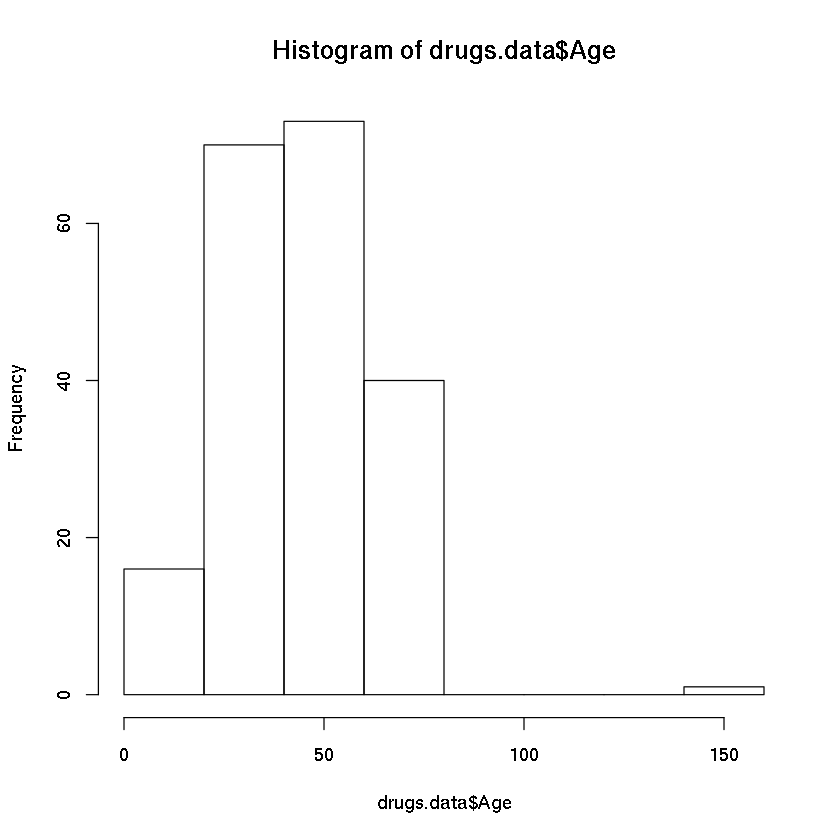

In [7]:
summary(drugs.data$Age)
hist(drugs.data$Age)

Se observó que hay un individuo con una edad de 145 lo cual se puede considerar bastante improbable ya que es un dato atípico, por lo tanto, se procederá a eliminar esta instancia.

[1] "Instances count: "


[1] 199

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15.00   31.00   45.00   44.42   58.00   74.00 

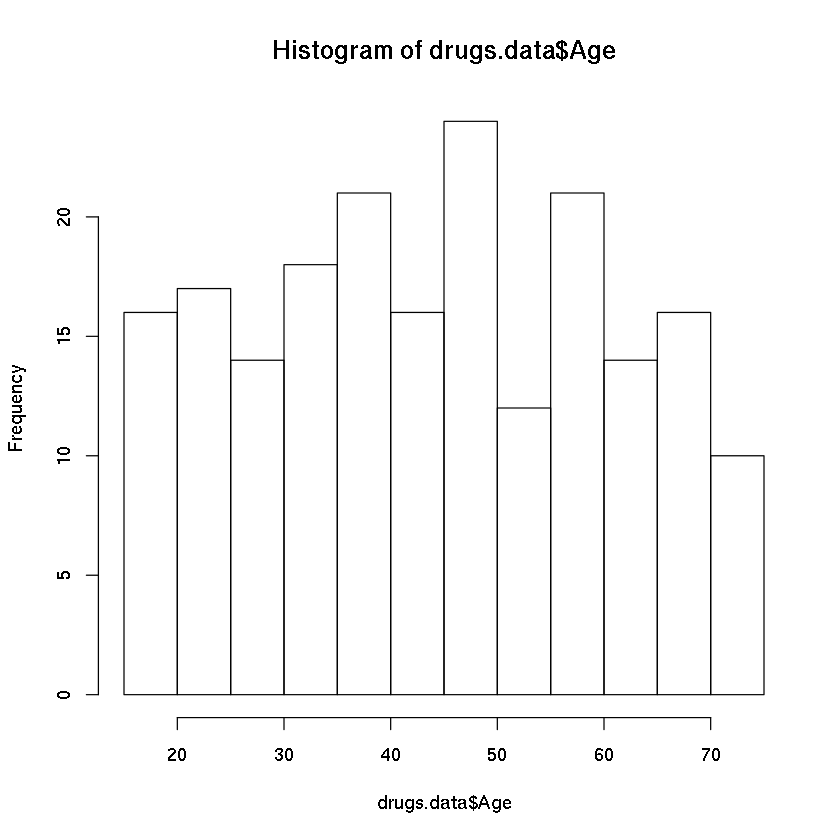

In [8]:
# We are going to delete all the instances whose age is greater than 115
drugs.data <- drugs.data[drugs.data$Age < 115,]
# Ensures no negative ages
drugs.data <- drugs.data[drugs.data$Age >= 0, ]
# Plots the new age column
print("Instances count: ")
length(drugs.data$Age)
summary(drugs.data$Age)
hist(drugs.data$Age)

Podemos ver que despues de eliminar las instancia con el dato atipo la distribuciòn de la variable Age es uniforme.

#### Sexo

F   M 
 96 103

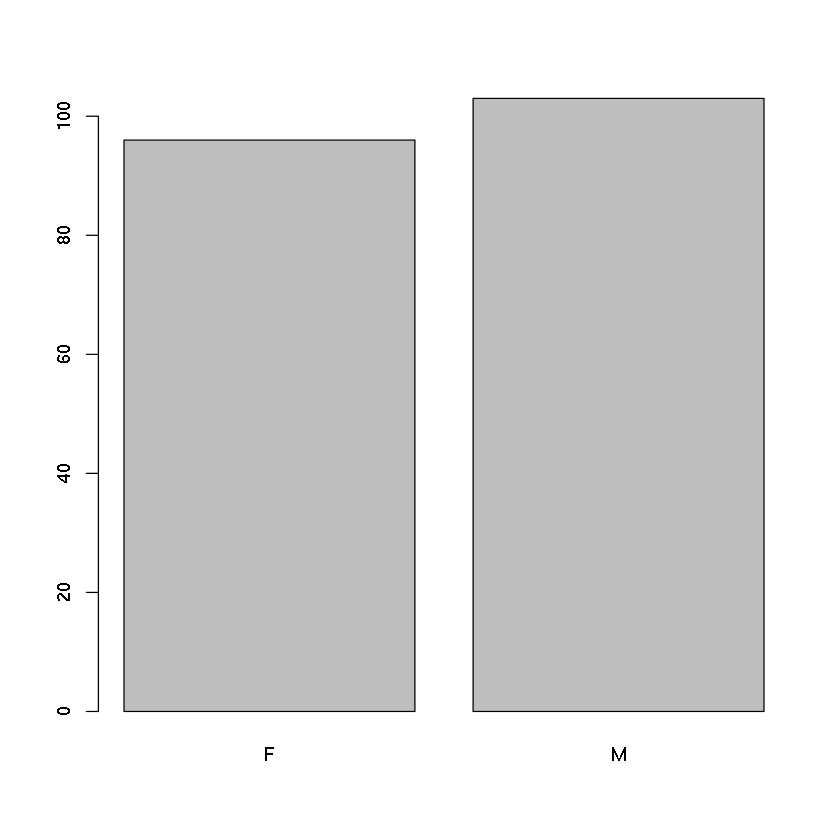

In [9]:
summary(drugs.data$Sex)

counts <- table(drugs.data$Sex)
barplot(counts)

Esta variable esta balanceada y no tiene nada atipico, sigamos con la siguiente

#### BP (Blood Pressure)

HIGH    LOW NORMAL 
    76     64     59

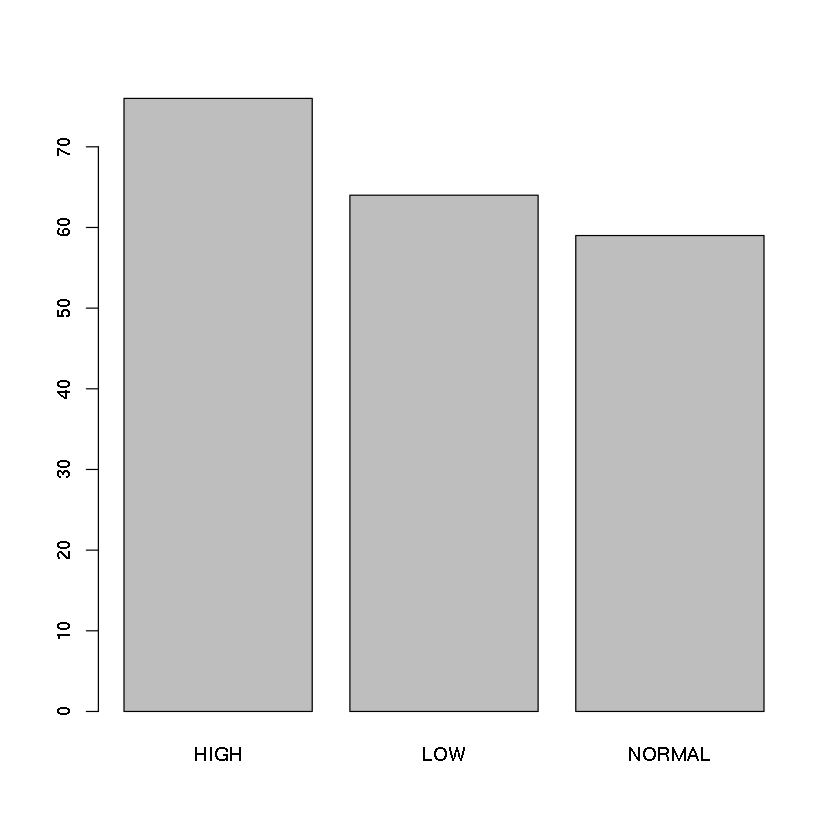

In [10]:
summary(drugs.data$BP)
# Plot frequency histogram
barplot(table(drugs.data$BP))

Esta variable tambien se ve bien.

#### Cholesterol

HIGH NORMAL 
   102     97

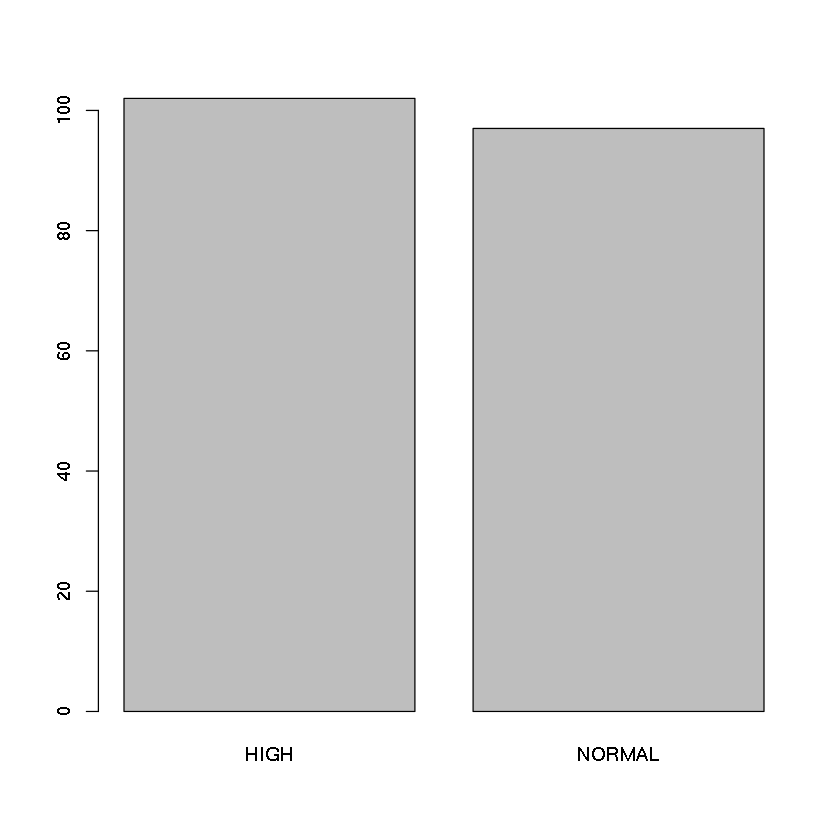

In [11]:
summary(drugs.data$Cholesterol)
barplot(table(drugs.data$Cholesterol))

Esta variable luce balanceada y no se observan datos atipicos.

#### Na

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.8489  0.5836  0.7214  0.6894  0.7980  0.8961 

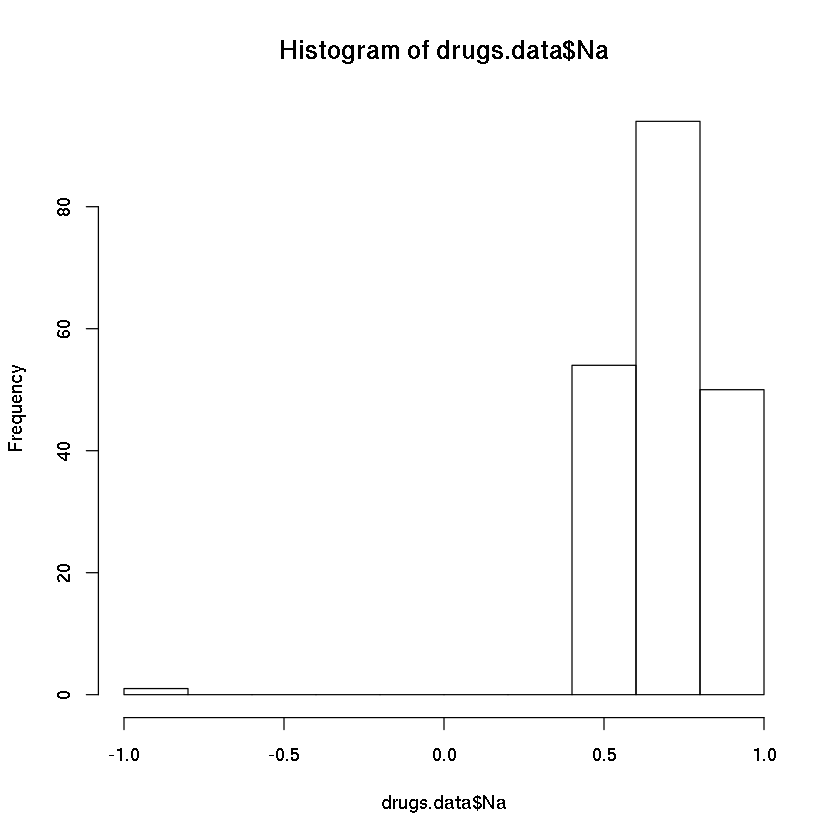

In [12]:
summary(drugs.data$Na)
# Plots histogram
hist(drugs.data$Na)

Se encontró que hay un dato atípico, una persona con un nivel de sodio de -0.85: 

Se sospecha que este valor no es humanamente posible (al menos que se este en la condición incapacitante de la muerte) aunque no se encontró una fuente médica confiable que permitiera comprobar esta afirmación, por lo tanto, se procederá a eliminar a esta persona de los registros.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5002  0.5855  0.7219  0.6972  0.7993  0.8961 

[1] "Instances count: "


[1] 198

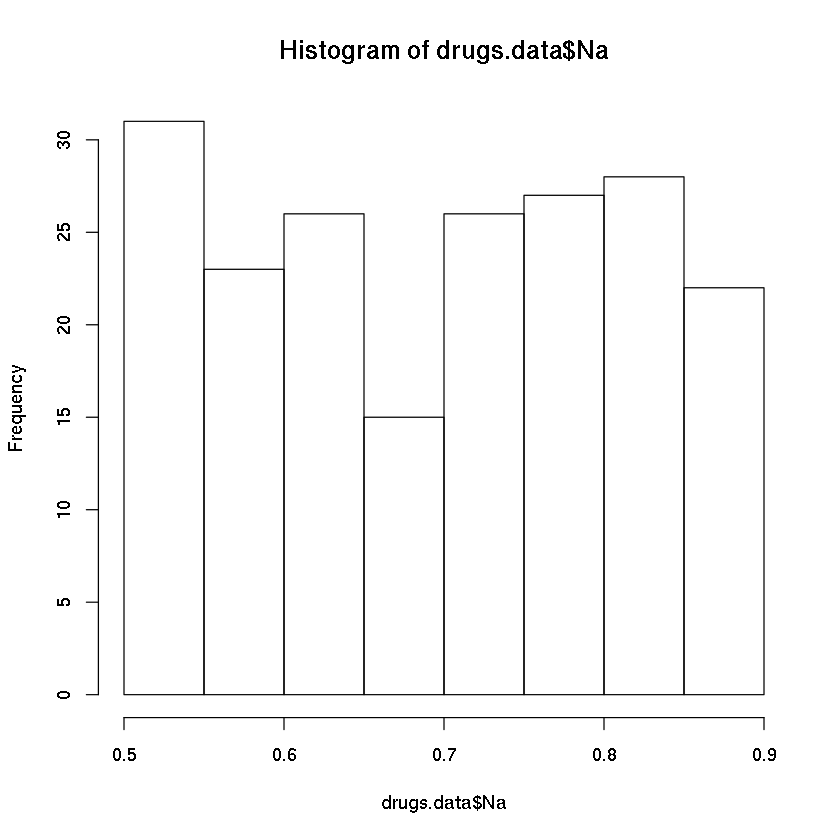

In [13]:
# Removes instances with negative Na levels
drugs.data = drugs.data[drugs.data$Na >= 0, ]
summary(drugs.data$Na)
hist(drugs.data$Na)

# Counts remaining number of instances
print("Instances count: ")
length(drugs.data$Na)

NOTA: Debido a que hay poquitos pacientes (instancias) con valores atípicos se decidió eliminar dichas instancias en lugar de reemplazar el valor del atributo en cuestión.

#### K

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02002 0.03487 0.04919 0.04997 0.06546 0.07979 

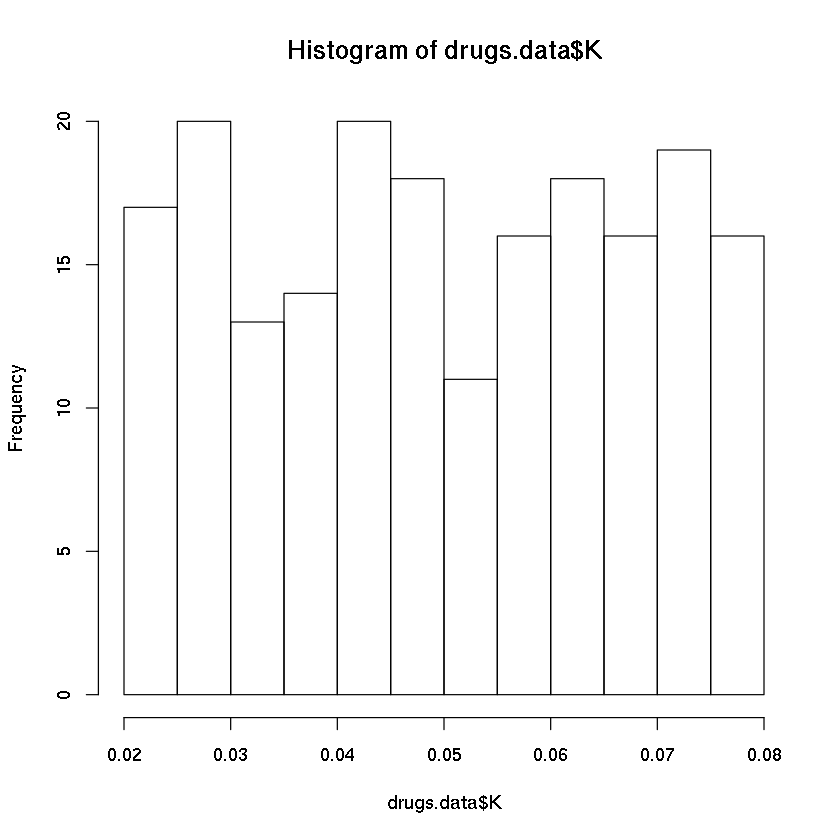

In [14]:
summary(drugs.data$K)
hist(drugs.data$K)

No se encontraron datos atipicos

#### Drugs (The class)

drugA drugB drugC drugX drugY 
   22    16    16    53    91

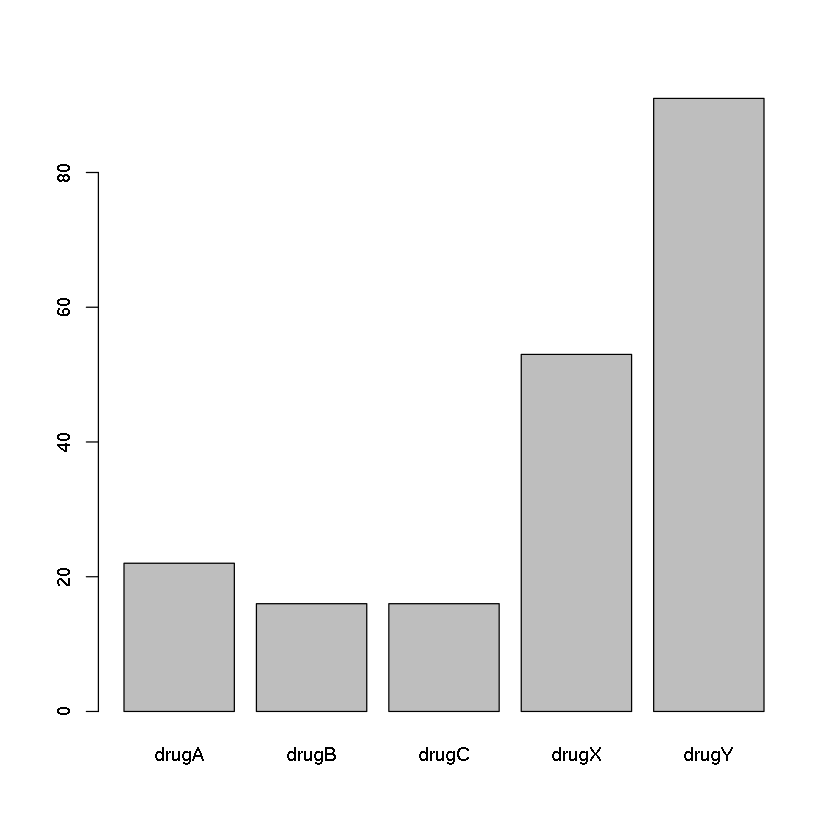

In [15]:
summary(drugs.data$Drug)
barplot(table(drugs.data$Drug))

Al observar la class se observa que esta desbalanceada, lo cual nos expone a un alto riesgo de overfitting, razón por la cual se procedió a balancearlos “adicionando instancias” usando la técnica SMOTE (Synthetic Minority Over-sampling Technique). Pero antes dividiremos los datos y aplicaremos este metodo solo al conjunto de entrenamiento.


Ademas cabe decir, que las variables numericas fueron normalizadas, y se eliminaron instancias con valores atipicos.

### Dividiendo el datase
Se procederà a dividir el dataset en dos partes 70% para entrenar los modelos y 30% para probar el modelo resultante.

Para esto usaremos la libreria caret

In [16]:
print(paste("Original Instance count: ", length(drugs.data$Sex)))
set.seed(3033)
intrain <- createDataPartition(y = drugs.data$Drug, p = 0.7, list = FALSE)
drugs.train <- drugs.data[intrain,]
drugs.test <- drugs.data[-intrain,]

print(paste("Train instance count: ", length(drugs.train$Age)))
print(paste("Test instance count: ", length(drugs.test$Age)))

[1] "Original Instance count:  198"
[1] "Train instance count:  142"
[1] "Test instance count:  56"


### Normalizando los datos
Se normalizò todas las variables continuas para asegurar que los
entrenamientos no sean muy sensibles a las diferencias de escala entre los valores de los atributos. Por ejemplo: Si observamos los valores de los atributos Age y Na veremos que el primero está en el rango **[15, 74]** y el segundo en el rango **[0.5, 0.896]**

#### Aclaraciòn normalizacion y estandarizacion
**Normalization** escala los datos al rango [0, 1] (method="range")

**Standardize** Le resta la media a los datos y la divide por la desviacion estandar (method=c("scale", "center"))

#### Notas sobre caret
The caret package in R provides a number of useful data transforms.

These transforms can be used in two ways.

**Standalone:** Transforms can be modeled from training data and applied to multiple datasets. The model of the transform is prepared using the preProcess() function and applied to a dataset using the predict() function.

**Training:** Transforms can prepared and applied automatically during model evaluation. Transforms applied during training are prepared using the preProcess() and passed to the train() function via the preProcess argument.

In [17]:
# calculate the pre-process parameters from the dataset (normalize)
preprocessParams <- preProcess(drugs.train, method=c("range"))
# transform the dataset using the parameters
drugs.train.norm <- predict(preprocessParams, drugs.train)
head(drugs.train.norm)

# Normalizing test set
# calculate the pre-process parameters from the dataset (normalize)
preprocessParams <- preProcess(drugs.test, method=c("range"))
drugs.test.norm <- predict(preprocessParams, drugs.test)
head(drugs.test.norm)

,Age,Sex,BP,Cholesterol,Na,K,Drug
2,0.5423729,M,LOW,HIGH,0.6040613,0.6098116,drugC
3,0.5423729,M,LOW,HIGH,0.4978693,0.8185590,drugC
4,0.2203390,F,NORMAL,HIGH,0.1604321,0.8745273,drugX
5,0.7796610,F,LOW,HIGH,0.1493482,0.1836496,drugY
6,0.1186441,F,NORMAL,HIGH,0.4464203,0.9809089,drugX
7,0.5762712,F,NORMAL,HIGH,0.7311884,0.4767928,drugY


,Age,Sex,BP,Cholesterol,Na,K,Drug
1,0.1355932,F,HIGH,HIGH,0.7444506,0.19967664,drugY
8,0.4406780,M,LOW,HIGH,0.6755729,0.88597862,drugC
12,0.3220339,F,HIGH,NORMAL,0.4126676,0.26298392,drugY
15,0.5932203,F,NORMAL,HIGH,0.8381800,0.80882062,drugX
20,0.2881356,F,HIGH,NORMAL,0.3479918,0.08317614,drugY
23,0.5423729,M,LOW,NORMAL,0.7887663,0.11369801,drugY


### Balanceando los datos de entrenamiento
Como se mencionò anteriormente, las instancias del dataset se encuentran desbalanceadas, procederemos a solucionar este problema aplicando un up-sampling

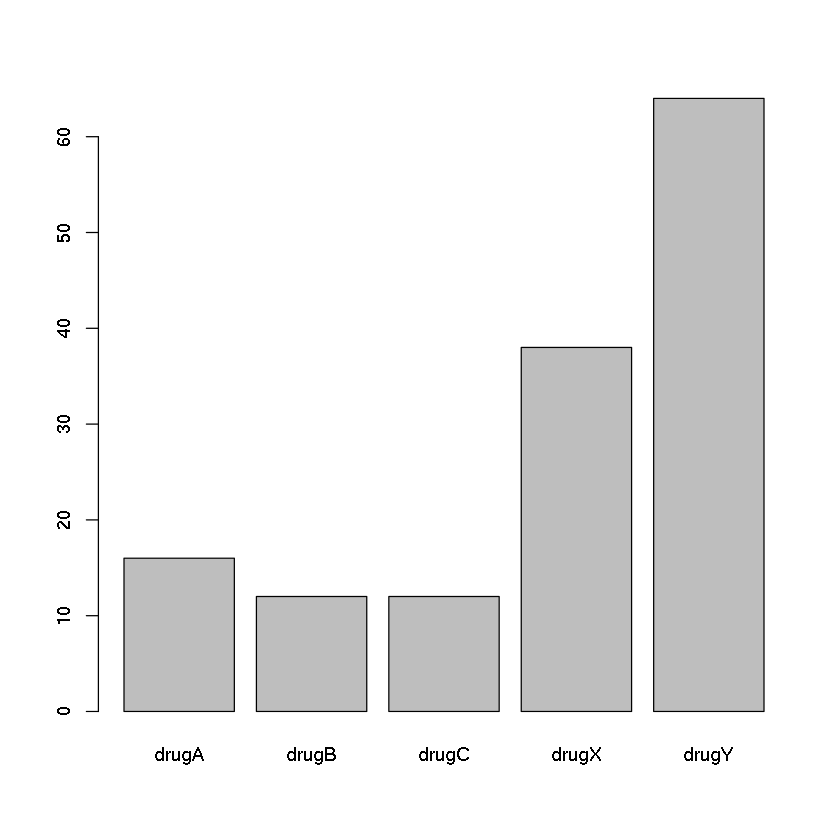

In [18]:
barplot(table(drugs.train.norm$Drug))

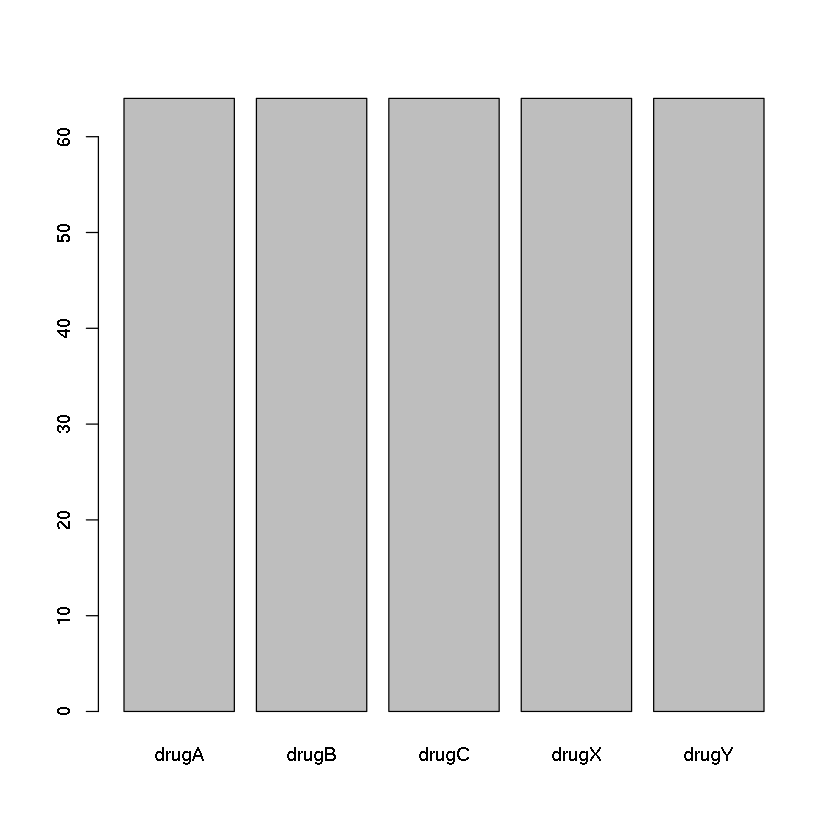

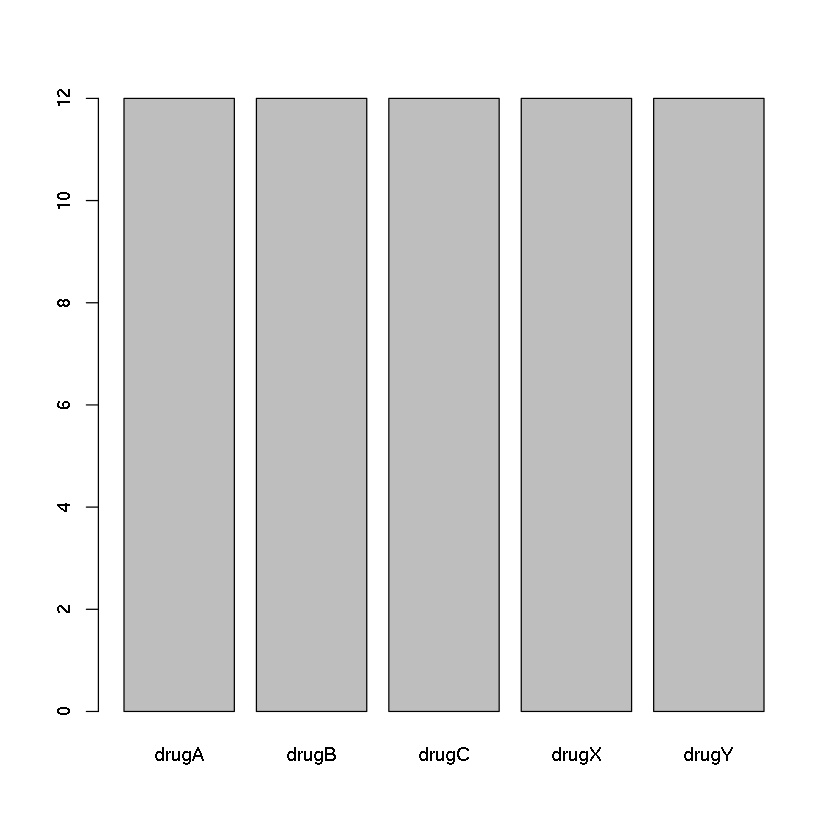

In [19]:
df <- upSample(x=drugs.train.norm[, -7], y=drugs.train.norm$Drug)
drugs.train.norm.up <- as.data.frame(df)
colnames(drugs.train.norm.up)[7] <- "Drug"
barplot(table(drugs.train.norm.up$Drug))

df <- downSample(x=drugs.train.norm[, -7], y=drugs.train.norm$Drug)
drugs.train.norm.down <- as.data.frame(df)
colnames(drugs.train.norm.down)[7] <- "Drug"
barplot(table(drugs.train.norm.down$Drug))

Notese que se realizo un up y un down sampling para probar empiricamente el resultado de estos en algunos algoritmos de aprendizaje de maquina.

### Dummying los datos de entrenamiento normalizados
A diferencia de WEKA en R no hay un manejo automatico de los atributos categoricos, en su lugar debemos aplicar una tecnica que se conoce como variables dummies, esto es requerido porque hay metodos de machine learning que unicamente aceptan valores numericos.

NOTA: Usaremos la libreria caret que facilita muchisimo las cosas, esta libreria podria considerarse el analogo a **scikitlearn** en python

In [20]:
# dummify the data
dmy <- dummyVars(" ~ .", data = drugs.train.norm.down)
drugs.train.norm.down.dummy <- data.frame(predict(dmy, newdata = drugs.train.norm.down))
head(drugs.train.norm.down.dummy)

# dummify the data
dmy <- dummyVars(" ~ .", data = drugs.train.norm.up)
drugs.train.norm.up.dummy <- data.frame(predict(dmy, newdata = drugs.train.norm.up))
head(drugs.train.norm.up.dummy)

# Dumimifying test set
dmy <- dummyVars(" ~ .", data=drugs.test)
drugs.test.dummy <- data.frame(predict(dmy, newdata=drugs.test))
head(drugs.test.dummy)

Age,Sex.F,Sex.M,BP.HIGH,BP.LOW,BP.NORMAL,Cholesterol.HIGH,Cholesterol.NORMAL,Na,K,Drug.drugA,Drug.drugB,Drug.drugC,Drug.drugX,Drug.drugY
0.4067797,0,1,1,0,0,1,0,0.5833028,0.9307968,1,0,0,0,0
0.3559322,1,0,1,0,0,1,0,0.5909515,0.7618713,1,0,0,0,0
0.4745763,0,1,1,0,0,1,0,0.3945621,0.4510424,1,0,0,0,0
0.1525424,0,1,1,0,0,0,1,0.2856674,0.7479838,1,0,0,0,0
0.4576271,0,1,1,0,0,0,1,0.9037200,0.7894288,1,0,0,0,0
0.3898305,1,0,1,0,0,0,1,0.5902518,0.7491048,1,0,0,0,0


Age,Sex.F,Sex.M,BP.HIGH,BP.LOW,BP.NORMAL,Cholesterol.HIGH,Cholesterol.NORMAL,Na,K,Drug.drugA,Drug.drugB,Drug.drugC,Drug.drugX,Drug.drugY
0.47457627,0,1,1,0,0,1,0,0.39456208,0.4510424,1,0,0,0,0
0.15254237,0,1,1,0,0,0,1,0.28566737,0.7479838,1,0,0,0,0
0.23728814,0,1,1,0,0,1,0,0.31600684,0.4787839,1,0,0,0,0
0.35593220,1,0,1,0,0,1,0,0.59095146,0.7618713,1,0,0,0,0
0.06779661,1,0,1,0,0,1,0,0.04244646,0.3147274,1,0,0,0,0
0.38983051,1,0,1,0,0,0,1,0.59025176,0.7491048,1,0,0,0,0


,Age,Sex.F,Sex.M,BP.HIGH,BP.LOW,BP.NORMAL,Cholesterol.HIGH,Cholesterol.NORMAL,Na,K,Drug.drugA,Drug.drugB,Drug.drugC,Drug.drugX,Drug.drugY
1,23,1,0,1,0,0,1,0,0.792535,0.031258,0,0,0,0,1
8,41,0,1,0,1,0,1,0,0.766635,0.069461,0,0,1,0,0
12,34,1,0,1,0,0,0,1,0.667775,0.034782,0,0,0,0,1
15,50,1,0,0,0,1,1,0,0.827780,0.065166,0,0,0,1,0
20,32,1,0,1,0,0,0,1,0.643455,0.024773,0,0,0,0,1
23,47,0,1,0,1,0,0,1,0.809199,0.026472,0,0,0,0,1


## Metodos de regresiòn
No se usará el método de regresión lineal porque el atributo a predecir es categórico en su lugar se usará el método de regresión logística el cual se usa cuando el atributo a predecir es categórico.

In [21]:
d <- drugs.train.norm.down

# We use multinom function instead of glm because we have a multi-class problem.
log <- multinom(d$Drug ~ ., data=d)
head(d)
# La regresion logistica de caret solo soporta 2 clases
#log <- train(drugs.train.norm$Drug ~ .,
#             data=drugs.train.norm,
#             method="glm",
#             family="binomial")
summary(log)

# weights:  45 (32 variable)
initial  value 96.566275 
iter  10 value 7.394522
iter  20 value 0.029708
final  value 0.000065 
converged


Age,Sex,BP,Cholesterol,Na,K,Drug
0.4067797,M,HIGH,HIGH,0.5833028,0.9307968,drugA
0.3559322,F,HIGH,HIGH,0.5909515,0.7618713,drugA
0.4745763,M,HIGH,HIGH,0.3945621,0.4510424,drugA
0.1525424,M,HIGH,NORMAL,0.2856674,0.7479838,drugA
0.4576271,M,HIGH,NORMAL,0.9037200,0.7894288,drugA
0.3898305,F,HIGH,NORMAL,0.5902518,0.7491048,drugA


Warning message in sqrt(diag(vc)):
“NaNs produced”

Call:
multinom(formula = d$Drug ~ ., data = d)

Coefficients:
      (Intercept)        Age       SexM     BPLOW  BPNORMAL CholesterolNORMAL
drugB  -142.40949 180.917961 -16.150604 -48.21200 -33.53107           3.24067
drugC   -15.16784  -5.045017  -2.258218 110.29817 -18.04822         -94.34071
drugX   -77.59186  -1.336102 -22.698097 125.61030 119.86732          13.61430
drugY    37.04186  45.214270 -26.427024  33.67704  14.81017           4.49657
              Na          K
drugB  51.038681   19.17168
drugC -14.040527   14.79708
drugX  -7.517563   37.60986
drugY 152.419076 -255.26116

Std. Errors:
      (Intercept)       Age       SexM     BPLOW BPNORMAL CholesterolNORMAL
drugB   17117.298 100993.08 113455.499       NaN 212502.5         133412.17
drugC    7904.739  28485.98   4273.367  69153.64      NaN               NaN
drugX   95228.685  75825.92 212760.866 105194.83 175787.3         177861.37
drugY  237181.793 392209.70 115445.630  57224.86 199851.0          86244.15
             N

### Probando el modelo
A continuaciòn probaremos el modelo con los datos de prueba **(drugs.test)**

In [22]:
# Perfomance utility function, receives two arrays
showComparission <- function (actual, predicted)
{
    # Creates list Actual vs Predicted 
    comparission <- data.frame(actual, predicted)
    colnames(comparission) <- c("Actual", "Predicted")
    head(comparission)
   
}

showROC <- function (actual, predicted)
{
    # ROC curve
    predictions <- as.numeric(predicted)
    roc.multi <- multiclass.roc(actual, predictions)
    summary(roc.multi)
}

showAcuraccy <- function (actual, predicted)
{
    # Computes the accuraccy
    errArr <- actual[predicted != actual]
    err <- length(errArr) / length(actual)
    
    
    print(paste("Accuraccy: ", 1-err))
}

In [23]:
d <- drugs.test.norm
# Removes class column from the test set
d_0 <- subset(drugs.test.norm, select=c(1, 2, 3, 4, 5, 6))

drugs.predicted <- predict(log, newdata=d_0)
class(drugs.predicted)
length(drugs.predicted)
length(d$Drug)

# Show perfomance info
showAcuraccy(actual=d$Drug, predicted=drugs.predicted)
#showROC(actual=d$Drug, predicted=drugs.predicted)
showComparission(actual=d$Drug, predicted=drugs.predicted)

confusionMatrix(drugs.predicted, d$Drug )

# Hoy to calcules the accuraccy https://datascienceplus.com/perform-logistic-regression-in-r/
# Cool way of compute the accuraccy
# missClassifiedErr = mean(drugs.predicted != d$Drug)
# print(paste("Accuraccy: ", 1-missClassifiedErr))

[1] "factor"

[1] 56

[1] 56

[1] "Accuraccy:  0.892857142857143"


Actual,Predicted
drugY,drugY
drugC,drugC
drugY,drugY
drugX,drugX
drugY,drugY
drugY,drugY


Confusion Matrix and Statistics

          Reference
Prediction drugA drugB drugC drugX drugY
     drugA     6     0     0     0     0
     drugB     0     4     0     0     1
     drugC     0     0     4     0     4
     drugX     0     0     0    15     1
     drugY     0     0     0     0    21

Overall Statistics
                                          
               Accuracy : 0.8929          
                 95% CI : (0.7812, 0.9597)
    No Information Rate : 0.4821          
    P-Value [Acc > NIR] : 1.011e-10       
                                          
                  Kappa : 0.8501          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: drugA Class: drugB Class: drugC Class: drugX
Sensitivity                1.0000      1.00000      1.00000       1.0000
Specificity                1.0000      0.98077      0.92308       0.9756
Pos Pred Value             1.0000      0.80000      0.50000       0.9375
Neg Pred Value        

Con un down-sampling se logro una precision de **89.28%**
Sin trabajar el overfiting se logro una precision de **89.28%**

Cabe notar que en weka se obtuvo una presicion de 98.47% para este mismo algoritmos, posiblemente debido a overfitting.

## KNN (Metodos basados en ejemplos)

In [24]:
# http://dataaspirant.com/2017/01/09/knn-implementation-r-using-caret-package/
# Undefined column selected https://stackoverflow.com/questions/44925565/caret-undefined-columns-selected
# kNN requires variables to be normalized or scaled.
data.train <- drugs.train.norm
head(data.train)
#trctrl <- trainControl(preProcOptions=list(tresh=0.8), method = "repeatedcv", number = 10, repeats = 3)
trctrl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
set.seed(3333)

knn_fit <- train(Drug ~ .,
                 data = data.train,
                 method = "knn",
                 trControl=trctrl,
                 # preProc="pca",
                 tuneLength = 10
                 )

knn_fit

,Age,Sex,BP,Cholesterol,Na,K,Drug
2,0.5423729,M,LOW,HIGH,0.6040613,0.6098116,drugC
3,0.5423729,M,LOW,HIGH,0.4978693,0.8185590,drugC
4,0.2203390,F,NORMAL,HIGH,0.1604321,0.8745273,drugX
5,0.7796610,F,LOW,HIGH,0.1493482,0.1836496,drugY
6,0.1186441,F,NORMAL,HIGH,0.4464203,0.9809089,drugX
7,0.5762712,F,NORMAL,HIGH,0.7311884,0.4767928,drugY


k-Nearest Neighbors 

142 samples
  6 predictor
  5 classes: 'drugA', 'drugB', 'drugC', 'drugX', 'drugY' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 128, 127, 128, 128, 128, 129, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.6813072  0.5463562
   7  0.6798714  0.5368996
   9  0.5970071  0.4076692
  11  0.6279839  0.4420416
  13  0.6717080  0.4977839
  15  0.7033319  0.5472044
  17  0.7216419  0.5684195
  19  0.7480083  0.6080612
  21  0.7761768  0.6524830
  23  0.7700546  0.6401919

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was k = 21.

### Probando el modelo

[1] "Accuraccy:  0.660714285714286"


Actual,Predicted
drugY,drugY
drugC,drugC
drugY,drugY
drugX,drugX
drugY,drugY
drugY,drugY


Confusion Matrix and Statistics

          Reference
Prediction drugA drugB drugC drugX drugY
     drugA     1     1     0     0     1
     drugB     0     1     0     0     0
     drugC     0     0     3     0     0
     drugX     0     0     0    10     4
     drugY     5     2     1     5    22

Overall Statistics
                                          
               Accuracy : 0.6607          
                 95% CI : (0.5219, 0.7819)
    No Information Rate : 0.4821          
    P-Value [Acc > NIR] : 0.005341        
                                          
                  Kappa : 0.4535          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: drugA Class: drugB Class: drugC Class: drugX
Sensitivity               0.16667      0.25000      0.75000       0.6667
Specificity               0.96000      1.00000      1.00000       0.9024
Pos Pred Value            0.33333      1.00000      1.00000       0.7143
Neg Pred Value        

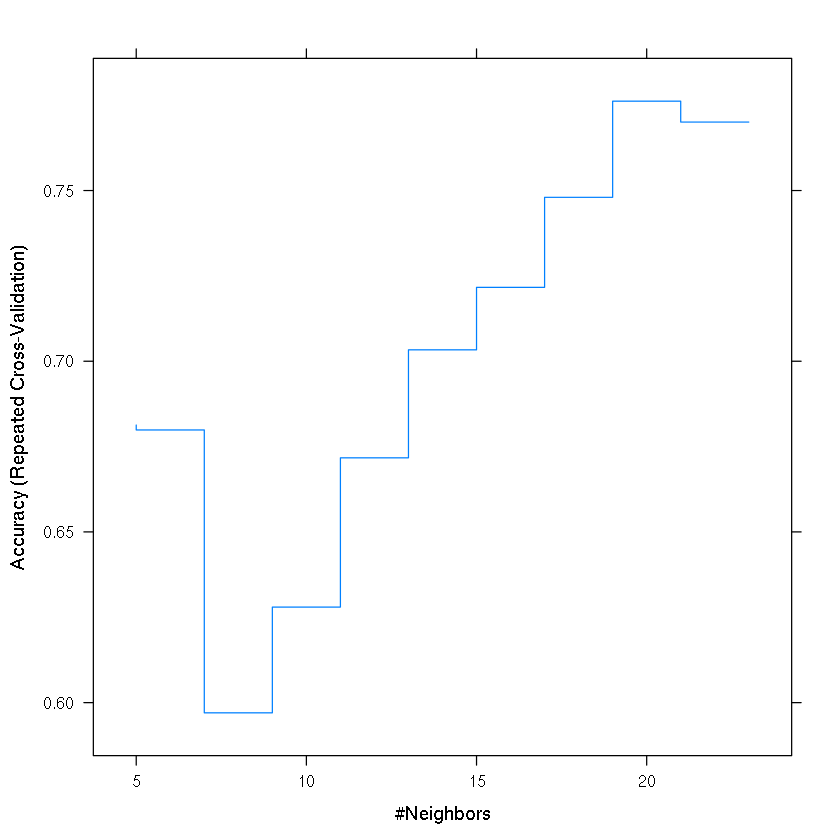

In [25]:
data.test <- drugs.test.norm

subset <- subset(data.test, select=c(1, 2, 3, 4, 5, 6))
drugs.predicted <- predict(knn_fit, newdata=data.test)

# Show perfomance
showAcuraccy(actual=data.test$Drug, predicted=drugs.predicted)
# showROC(actual=data.test$Drug, predicted=drugs.predicted)

showComparission(actual=data.test$Drug, predicted=drugs.predicted)

confusionMatrix(drugs.predicted, data.test$Drug )

#Plotting yields Number of Neighbours Vs accuracy (based on repeated cross validation)
plot(knn_fit, print.thres = 0.5, type="S")

Caret usa la precision del modelo para elegir el valor mas optimo para K (en este caso 21), la precision mas alta que se obtuvo fue de **71.42%**, cabe decir que al aplicar este mismo metodo en weka con k=20 se obtuvo una precisiòn del **73.66%** lo cual supone una precision muy similar.

Sin embargo en weka mayores precisiones para valores pequeños de K.

## Arboles de decision
el output de este algoritmo tiene la gran ventaja de que es muy fácil de entender por las personas lo que facilita su aplicación para futuras instancias de ejemplo.

Este modelo tiene el riesgo de quedar sobreajustado si las ramas son muy profundas.

In [26]:
# A comprehensive index of R packages and documentation from CRAN, Bioconductor, GitHub and R-Forge.
# rdrr.io
# https://rdrr.io/rforge/caret/man/models.html

data.train <- drugs.train.norm
head(data.train)
trctrl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
set.seed(3333)

# J48 is an decision tree algorithm (We use this in weka)
tree <- train(Drug ~ .,
                 data = data.train,
                 method = "J48",
                 trControl=trctrl,
                 # preProc="pca",
                 tuneLength = 10
                 )
tree

,Age,Sex,BP,Cholesterol,Na,K,Drug
2,0.5423729,M,LOW,HIGH,0.6040613,0.6098116,drugC
3,0.5423729,M,LOW,HIGH,0.4978693,0.8185590,drugC
4,0.2203390,F,NORMAL,HIGH,0.1604321,0.8745273,drugX
5,0.7796610,F,LOW,HIGH,0.1493482,0.1836496,drugY
6,0.1186441,F,NORMAL,HIGH,0.4464203,0.9809089,drugX
7,0.5762712,F,NORMAL,HIGH,0.7311884,0.4767928,drugY


C4.5-like Trees 

142 samples
  6 predictor
  5 classes: 'drugA', 'drugB', 'drugC', 'drugX', 'drugY' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 128, 127, 128, 128, 128, 129, ... 
Resampling results across tuning parameters:

  C           M   Accuracy   Kappa    
  0.01000000   1  0.8744667  0.8166342
  0.01000000   2  0.8765058  0.8193005
  0.01000000   3  0.8794118  0.8250125
  0.01000000   4  0.8655778  0.8046872
  0.01000000   5  0.8560052  0.7892594
  0.01000000   6  0.8560052  0.7892594
  0.01000000   7  0.8607671  0.7955520
  0.01000000   8  0.8256611  0.7454283
  0.01000000   9  0.7742936  0.6682340
  0.01000000  10  0.7741105  0.6681879
  0.06444444   1  0.8770308  0.8206224
  0.06444444   2  0.8766889  0.8201327
  0.06444444   3  0.8795949  0.8261588
  0.06444444   4  0.8681419  0.8091394
  0.06444444   5  0.8604496  0.7975968
  0.06444444   6  0.8604496  0.7972825
  0.06444444   7  0.8652115  0.8030265
  0.06444444  

#### Bonus: Vamos a jugar con el random forest

In [27]:
# rdrr.io
# https://rdrr.io/rforge/caret/man/models.html

data.train <- drugs.train.norm
head(data.train)
trctrl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
set.seed(3333)

# rf: random forest
forest <- train(Drug ~ .,
                 data = data.train,
                 method = "rf",
                 trControl=trctrl,
                 # preProc="pca",
                 tuneLength = 10
                 )
forest

,Age,Sex,BP,Cholesterol,Na,K,Drug
2,0.5423729,M,LOW,HIGH,0.6040613,0.6098116,drugC
3,0.5423729,M,LOW,HIGH,0.4978693,0.8185590,drugC
4,0.2203390,F,NORMAL,HIGH,0.1604321,0.8745273,drugX
5,0.7796610,F,LOW,HIGH,0.1493482,0.1836496,drugY
6,0.1186441,F,NORMAL,HIGH,0.4464203,0.9809089,drugX
7,0.5762712,F,NORMAL,HIGH,0.7311884,0.4767928,drugY


note: only 6 unique complexity parameters in default grid. Truncating the grid to 6 .



randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



Random Forest 

142 samples
  6 predictor
  5 classes: 'drugA', 'drugB', 'drugC', 'drugX', 'drugY' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 128, 127, 128, 128, 128, 129, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.9286691  0.8934429
  3     0.9194628  0.8813308
  4     0.9073748  0.8644464
  5     0.9049695  0.8614586
  6     0.8930403  0.8459799
  7     0.8814286  0.8282388

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 2.

### Probando los modelos

Vamos a probar la efectividad del random forest y la del decision tree (J48)

#### Efectividad decision tree (J48)

[1] "Accuraccy:  0.946428571428571"


Actual,Predicted
drugY,drugY
drugC,drugC
drugY,drugY
drugX,drugX
drugY,drugY
drugY,drugY


Confusion Matrix and Statistics

          Reference
Prediction drugA drugB drugC drugX drugY
     drugA     6     1     0     0     0
     drugB     0     3     0     0     1
     drugC     0     0     4     0     1
     drugX     0     0     0    15     0
     drugY     0     0     0     0    25

Overall Statistics
                                          
               Accuracy : 0.9464          
                 95% CI : (0.8513, 0.9888)
    No Information Rate : 0.4821          
    P-Value [Acc > NIR] : 6.552e-14       
                                          
                  Kappa : 0.9222          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: drugA Class: drugB Class: drugC Class: drugX
Sensitivity                1.0000      0.75000      1.00000       1.0000
Specificity                0.9800      0.98077      0.98077       1.0000
Pos Pred Value             0.8571      0.75000      0.80000       1.0000
Neg Pred Value        

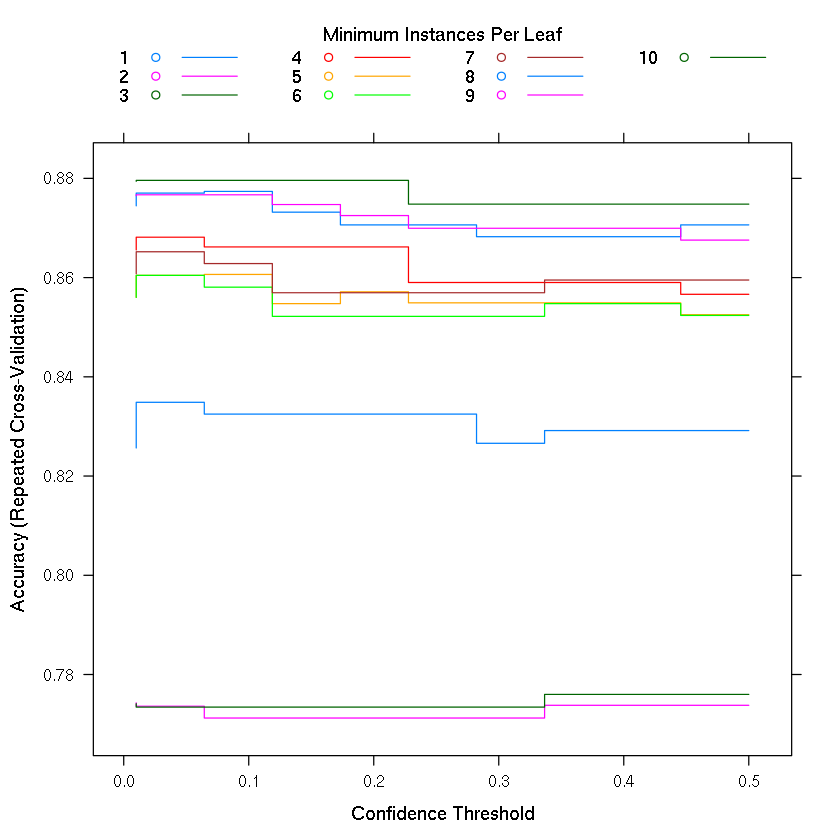

In [28]:
data.test <- drugs.test.norm

subset <- subset(data.test, select=c(1, 2, 3, 4, 5, 6))
drugs.predicted <- predict(tree, newdata=data.test)

# Show perfomance
showAcuraccy(actual=data.test$Drug, predicted=drugs.predicted)
# showROC(actual=data.test$Drug, predicted=drugs.predicted)

showComparission(actual=data.test$Drug, predicted=drugs.predicted)

confusionMatrix(drugs.predicted, data.test$Drug )

#Plotting yields Number of Neighbours Vs accuracy (based on repeated cross validation)
plot(tree, print.thres = 0.5, type="S")

#### Efectividad random forest

[1] "Accuraccy:  0.946428571428571"


Actual,Predicted
drugY,drugY
drugC,drugC
drugY,drugY
drugX,drugX
drugY,drugY
drugY,drugY


Confusion Matrix and Statistics

          Reference
Prediction drugA drugB drugC drugX drugY
     drugA     6     0     0     0     0
     drugB     0     4     0     0     0
     drugC     0     0     4     0     1
     drugX     0     0     0    15     2
     drugY     0     0     0     0    24

Overall Statistics
                                          
               Accuracy : 0.9464          
                 95% CI : (0.8513, 0.9888)
    No Information Rate : 0.4821          
    P-Value [Acc > NIR] : 6.552e-14       
                                          
                  Kappa : 0.9223          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: drugA Class: drugB Class: drugC Class: drugX
Sensitivity                1.0000      1.00000      1.00000       1.0000
Specificity                1.0000      1.00000      0.98077       0.9512
Pos Pred Value             1.0000      1.00000      0.80000       0.8824
Neg Pred Value        

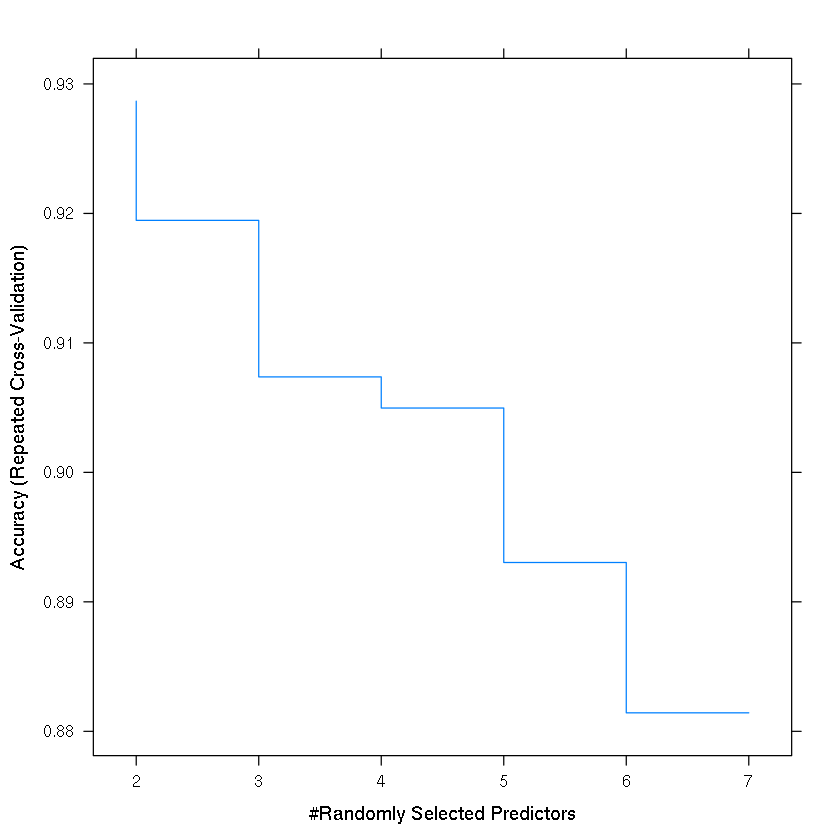

In [29]:
data.test <- drugs.test.norm

subset <- subset(data.test, select=c(1, 2, 3, 4, 5, 6))
drugs.predicted <- predict(forest, newdata=data.test)

# Show perfomance
showAcuraccy(actual=data.test$Drug, predicted=drugs.predicted)
# showROC(actual=data.test$Drug, predicted=drugs.predicted)

showComparission(actual=data.test$Drug, predicted=drugs.predicted)

confusionMatrix(drugs.predicted, data.test$Drug )

#Plotting yields Number of Neighbours Vs accuracy (based on repeated cross validation)
plot(forest, print.thres = 0.5, type="S")

Curiosamente la precision de los dos metodos es similar (**94.64%**), sin embargo el random forest llego a la respuesta mucho mas rapido que el decision tree, este ultimo tardo aproximadamente un minuto calculando la misma.

Cuando se aplico este metodo en weka la maxima efectividad que logro fue de **91.22%** cuando **minimumInstancesPerLeaf=4**

## Naive Bayes
clasificador probabilístico que se fundamenta en el teorema de Bayes de probabilidad condicional.

In [30]:
# rdrr.io
# https://rdrr.io/rforge/caret/man/models.html

data.train <- drugs.train.norm
head(data.train)
trctrl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
set.seed(3333)

# nb: Naive Bayes
bayes <- train(Drug ~ .,
                 data = data.train,
                 method = "nb",
                 trControl=trctrl,
                 tuneLength = 10
                 )
bayes

,Age,Sex,BP,Cholesterol,Na,K,Drug
2,0.5423729,M,LOW,HIGH,0.6040613,0.6098116,drugC
3,0.5423729,M,LOW,HIGH,0.4978693,0.8185590,drugC
4,0.2203390,F,NORMAL,HIGH,0.1604321,0.8745273,drugX
5,0.7796610,F,LOW,HIGH,0.1493482,0.1836496,drugY
6,0.1186441,F,NORMAL,HIGH,0.4464203,0.9809089,drugX
7,0.5762712,F,NORMAL,HIGH,0.7311884,0.4767928,drugY


Loading required package: MASS
Warning message:
“model fit failed for Fold01.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: BPLOW, BPNORMAL, CholesterolNORMAL
”Warning message:
“model fit failed for Fold02.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: BPLOW, BPNORMAL, CholesterolNORMAL
”Warning message:
“model fit failed for Fold03.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: BPLOW, BPNORMAL, CholesterolNORMAL
”Warning message:
“model fit failed for Fold04.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: BPLOW

Naive Bayes 

142 samples
  6 predictor
  5 classes: 'drugA', 'drugB', 'drugC', 'drugX', 'drugY' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 128, 127, 128, 128, 128, 129, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa    
  FALSE            NaN        NaN
   TRUE      0.6790828  0.4858413

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were fL = 0, usekernel = TRUE and adjust
 = 1.

### Probando el modelo

[1] "Accuraccy:  0.642857142857143"


Actual,Predicted
drugY,drugY
drugC,drugX
drugY,drugY
drugX,drugX
drugY,drugY
drugY,drugY


Confusion Matrix and Statistics

          Reference
Prediction drugA drugB drugC drugX drugY
     drugA     0     0     0     0     0
     drugB     0     1     0     0     0
     drugC     0     0     0     0     0
     drugX     4     2     4    11     3
     drugY     2     1     0     4    24

Overall Statistics
                                          
               Accuracy : 0.6429          
                 95% CI : (0.5036, 0.7664)
    No Information Rate : 0.4821          
    P-Value [Acc > NIR] : 0.01128         
                                          
                  Kappa : 0.4212          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: drugA Class: drugB Class: drugC Class: drugX
Sensitivity                0.0000      0.25000      0.00000       0.7333
Specificity                1.0000      1.00000      1.00000       0.6829
Pos Pred Value                NaN      1.00000          NaN       0.4583
Neg Pred Value        

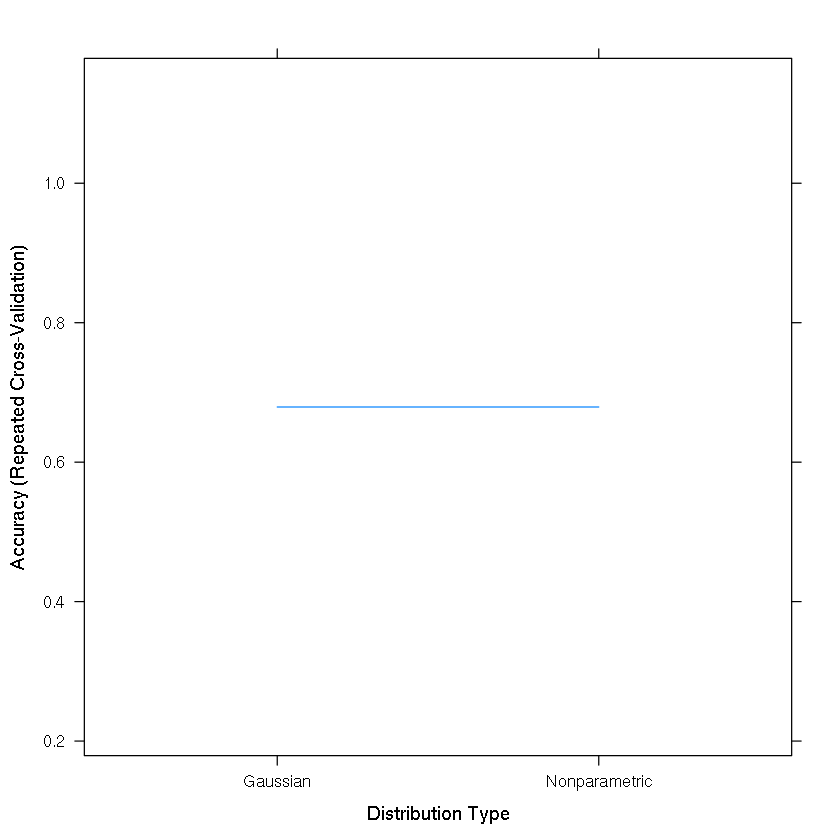

In [31]:
data.test <- drugs.test.norm

subset <- subset(data.test, select=c(1, 2, 3, 4, 5, 6))
drugs.predicted <- predict(bayes, newdata=data.test)

# Show perfomance
showAcuraccy(actual=data.test$Drug, predicted=drugs.predicted)
# showROC(actual=data.test$Drug, predicted=drugs.predicted)

showComparission(actual=data.test$Drug, predicted=drugs.predicted)

confusionMatrix(drugs.predicted, data.test$Drug )

#Plotting yields Number of Neighbours Vs accuracy (based on repeated cross validation)
plot(bayes, print.thres = 0.5, type="S")

Se logro una efectividad del **64.29%** a diferencia del **90.45%** logrado en weka

## Neuronal Networks
Debido a que en el problema de clasificación que estamos trabajando la clase tiene mas de 2 valores se procederá a usar un perceptrón multicapa ya que esta red permite establecer regiones de decisión mucho más complejas.

In [32]:
# rdrr.io
# https://rdrr.io/rforge/caret/man/models.html

data.train <- drugs.train.norm
head(data.train)
trctrl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
set.seed(3333)

# nnet: Neuronal networks
neuronal <- train(Drug ~ .,
                 data = data.train,
                 method = "nnet",
                 trControl=trctrl,
                 tuneLength = 10
                 )

,Age,Sex,BP,Cholesterol,Na,K,Drug
2,0.5423729,M,LOW,HIGH,0.6040613,0.6098116,drugC
3,0.5423729,M,LOW,HIGH,0.4978693,0.8185590,drugC
4,0.2203390,F,NORMAL,HIGH,0.1604321,0.8745273,drugX
5,0.7796610,F,LOW,HIGH,0.1493482,0.1836496,drugY
6,0.1186441,F,NORMAL,HIGH,0.4464203,0.9809089,drugX
7,0.5762712,F,NORMAL,HIGH,0.7311884,0.4767928,drugY


# weights:  18
initial  value 226.446685 
iter  10 value 128.648077
iter  20 value 86.979727
iter  30 value 83.610366
iter  40 value 83.600465
iter  50 value 83.558012
iter  60 value 83.255524
iter  70 value 82.864739
iter  80 value 82.675334
iter  90 value 82.586875
iter 100 value 82.523370
final  value 82.523370 
stopped after 100 iterations
# weights:  44
initial  value 219.606591 
iter  10 value 99.947743
iter  20 value 55.627531
iter  30 value 45.020941
iter  40 value 42.933937
iter  50 value 42.151453
iter  60 value 41.654927
iter  70 value 41.263461
iter  80 value 40.660051
iter  90 value 39.867279
iter 100 value 39.772275
final  value 39.772275 
stopped after 100 iterations
# weights:  70
initial  value 206.103728 
iter  10 value 47.295718
iter  20 value 9.476172
iter  30 value 0.188341
iter  40 value 0.003633
iter  50 value 0.000390
iter  60 value 0.000174
final  value 0.000066 
converged
# weights:  96
initial  value 248.212553 
iter  10 value 31.348630
iter  20 value 1.96474

### Probando el modelo

[1] "Accuraccy:  0.964285714285714"


Actual,Predicted
drugY,drugY
drugC,drugC
drugY,drugY
drugX,drugX
drugY,drugY
drugY,drugY


Confusion Matrix and Statistics

          Reference
Prediction drugA drugB drugC drugX drugY
     drugA     6     0     0     0     0
     drugB     0     4     0     0     1
     drugC     0     0     4     0     1
     drugX     0     0     0    15     0
     drugY     0     0     0     0    25

Overall Statistics
                                          
               Accuracy : 0.9643          
                 95% CI : (0.8769, 0.9956)
    No Information Rate : 0.4821          
    P-Value [Acc > NIR] : 3.328e-15       
                                          
                  Kappa : 0.9481          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: drugA Class: drugB Class: drugC Class: drugX
Sensitivity                1.0000      1.00000      1.00000       1.0000
Specificity                1.0000      0.98077      0.98077       1.0000
Pos Pred Value             1.0000      0.80000      0.80000       1.0000
Neg Pred Value        

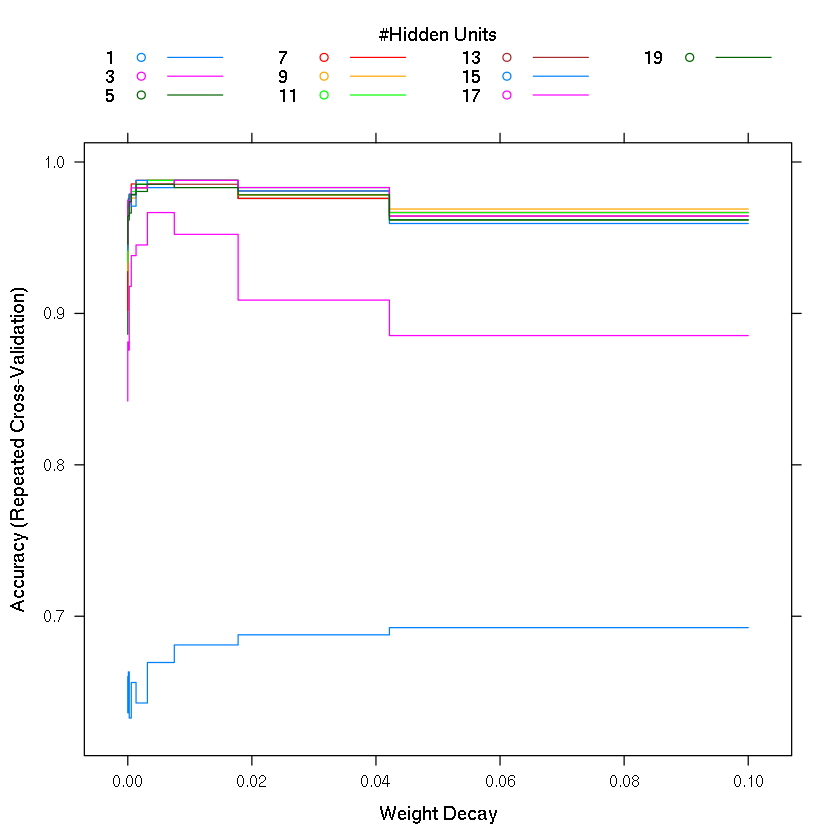

In [33]:
data.test <- drugs.test.norm

subset <- subset(data.test, select=c(1, 2, 3, 4, 5, 6))
drugs.predicted <- predict(neuronal, newdata=data.test)

# Show perfomance
showAcuraccy(actual=data.test$Drug, predicted=drugs.predicted)
# showROC(actual=data.test$Drug, predicted=drugs.predicted)

showComparission(actual=data.test$Drug, predicted=drugs.predicted)

confusionMatrix(drugs.predicted, data.test$Drug )

#Plotting yields Number of Neighbours Vs accuracy (based on repeated cross validation)
plot(neuronal, print.thres = 0.5, type="S")

Con la red neuronal se logrò una efectividad del **96.44%** la cual hasta el momento es la mas alta, cabe notar que demoro mas de 1 minuto calcular el modelo de la red neuronal. 

## Support Vector Machine
Este método es bastante resistente al sobre ajuste porque el modelo depende de relativamente pocos puntos en el dataset.

Vamos a probar una SVM con kernel radial y una con kernel lineal.

### SVM kernel lineal

In [34]:
# rdrr.io
# https://rdrr.io/rforge/caret/man/models.html

data.train <- drugs.train.norm
head(data.train)
trctrl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
set.seed(3333)

svmlinear <- train(Drug ~ .,
                 data = data.train,
                 method = "svmLinear",
                 trControl=trctrl,
                 tuneLength = 10
                 )

svmlinear

,Age,Sex,BP,Cholesterol,Na,K,Drug
2,0.5423729,M,LOW,HIGH,0.6040613,0.6098116,drugC
3,0.5423729,M,LOW,HIGH,0.4978693,0.8185590,drugC
4,0.2203390,F,NORMAL,HIGH,0.1604321,0.8745273,drugX
5,0.7796610,F,LOW,HIGH,0.1493482,0.1836496,drugY
6,0.1186441,F,NORMAL,HIGH,0.4464203,0.9809089,drugX
7,0.5762712,F,NORMAL,HIGH,0.7311884,0.4767928,drugY



Attaching package: ‘kernlab’

The following object is masked from ‘package:ggplot2’:

    alpha



Support Vector Machines with Linear Kernel 

142 samples
  6 predictor
  5 classes: 'drugA', 'drugB', 'drugC', 'drugX', 'drugY' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 128, 127, 128, 128, 128, 129, ... 
Resampling results:

  Accuracy   Kappa   
  0.9576557  0.939228

Tuning parameter 'C' was held constant at a value of 1

### Probando modelo (SVM kernel lineal)

In [35]:
data.test <- drugs.test.norm

subset <- subset(data.test, select=c(1, 2, 3, 4, 5, 6))
drugs.predicted <- predict(svmlinear, newdata=data.test)

# Show perfomance
showAcuraccy(actual=data.test$Drug, predicted=drugs.predicted)
# showROC(actual=data.test$Drug, predicted=drugs.predicted)

showComparission(actual=data.test$Drug, predicted=drugs.predicted)

confusionMatrix(drugs.predicted, data.test$Drug )


[1] "Accuraccy:  0.875"


Actual,Predicted
drugY,drugY
drugC,drugC
drugY,drugY
drugX,drugX
drugY,drugY
drugY,drugY


Confusion Matrix and Statistics

          Reference
Prediction drugA drugB drugC drugX drugY
     drugA     6     0     0     0     0
     drugB     0     4     0     0     1
     drugC     0     0     4     0     2
     drugX     0     0     0    15     4
     drugY     0     0     0     0    20

Overall Statistics
                                          
               Accuracy : 0.875           
                 95% CI : (0.7593, 0.9482)
    No Information Rate : 0.4821          
    P-Value [Acc > NIR] : 7.936e-10       
                                          
                  Kappa : 0.8243          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: drugA Class: drugB Class: drugC Class: drugX
Sensitivity                1.0000      1.00000      1.00000       1.0000
Specificity                1.0000      0.98077      0.96154       0.9024
Pos Pred Value             1.0000      0.80000      0.66667       0.7895
Neg Pred Value        

### SVM Kernel circular

In [36]:
# rdrr.io
# https://rdrr.io/rforge/caret/man/models.html

data.train <- drugs.train.norm
head(data.train)
trctrl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
set.seed(3333)


svmradial <- train(Drug ~ .,
                 data = data.train,
                 method = "svmRadial",
                 trControl=trctrl,
                 tuneLength = 10
                 )

svmradial

,Age,Sex,BP,Cholesterol,Na,K,Drug
2,0.5423729,M,LOW,HIGH,0.6040613,0.6098116,drugC
3,0.5423729,M,LOW,HIGH,0.4978693,0.8185590,drugC
4,0.2203390,F,NORMAL,HIGH,0.1604321,0.8745273,drugX
5,0.7796610,F,LOW,HIGH,0.1493482,0.1836496,drugY
6,0.1186441,F,NORMAL,HIGH,0.4464203,0.9809089,drugX
7,0.5762712,F,NORMAL,HIGH,0.7311884,0.4767928,drugY


Support Vector Machines with Radial Basis Function Kernel 

142 samples
  6 predictor
  5 classes: 'drugA', 'drugB', 'drugC', 'drugX', 'drugY' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 128, 127, 128, 128, 128, 129, ... 
Resampling results across tuning parameters:

  C       Accuracy   Kappa     
    0.25  0.4511248  0.00000000
    0.50  0.4901990  0.08373646
    1.00  0.6522962  0.42647262
    2.00  0.7417051  0.59406455
    4.00  0.7461495  0.60238673
    8.00  0.7461495  0.60238673
   16.00  0.7461495  0.60238673
   32.00  0.7461495  0.60238673
   64.00  0.7461495  0.60238673
  128.00  0.7461495  0.60238673

Tuning parameter 'sigma' was held constant at a value of 0.0955581
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were sigma = 0.0955581 and C = 4.

### Probando modelo (SVM kernel radial)

[1] "Accuraccy:  0.821428571428571"


Actual,Predicted
drugY,drugY
drugC,drugC
drugY,drugY
drugX,drugX
drugY,drugY
drugY,drugY


Confusion Matrix and Statistics

          Reference
Prediction drugA drugB drugC drugX drugY
     drugA     6     0     0     0     0
     drugB     0     3     0     0     0
     drugC     0     0     2     0     2
     drugX     0     0     0    10     0
     drugY     0     1     2     5    25

Overall Statistics
                                         
               Accuracy : 0.8214         
                 95% CI : (0.696, 0.9109)
    No Information Rate : 0.4821         
    P-Value [Acc > NIR] : 1.632e-07      
                                         
                  Kappa : 0.7243         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: drugA Class: drugB Class: drugC Class: drugX
Sensitivity                1.0000      0.75000      0.50000       0.6667
Specificity                1.0000      1.00000      0.96154       1.0000
Pos Pred Value             1.0000      1.00000      0.50000       1.0000
Neg Pred Value             1.0

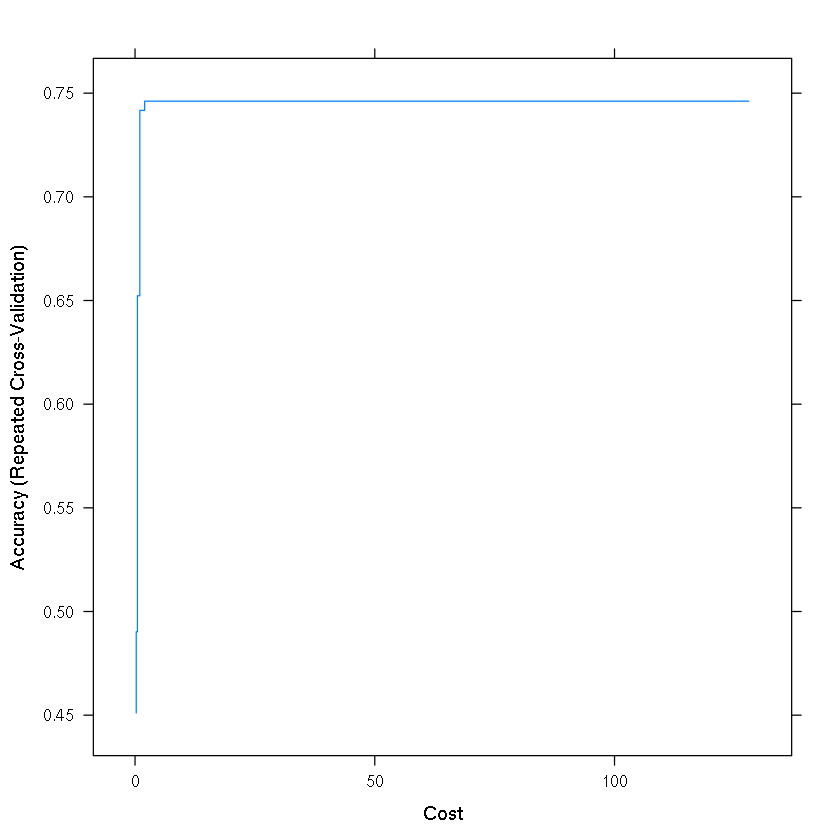

In [37]:
data.test <- drugs.test.norm

subset <- subset(data.test, select=c(1, 2, 3, 4, 5, 6))
drugs.predicted <- predict(svmradial, newdata=data.test)

# Show perfomance
showAcuraccy(actual=data.test$Drug, predicted=drugs.predicted)
# showROC(actual=data.test$Drug, predicted=drugs.predicted)

showComparission(actual=data.test$Drug, predicted=drugs.predicted)

confusionMatrix(drugs.predicted, data.test$Drug )

#Plotting yields Number of Neighbours Vs accuracy (based on repeated cross validation)
plot(svmradial, print.thres = 0.5, type="S")

La SVM con kernel lineal logro una efectividad del **87.50%** lo cual nos puede indicar que nuestro dataset es linealmente separable. 

# Conclusiones, Eligiendo a los ganadores
A continuación, se compacta en una tabla el porcentaje de instancias correctamente clasificadas por cada método de aprendizaje.

Metodo de Aprendizaje | Accuracy |
----|-----|----------|
Regresion logistica | **89.28%** |
KNN | **71.42%** |
Decision Tree | **94.64%** |
Naive Bayes | **64.29%** |
Neuronal Network | **96.44%** |
SVM Kernel Lineal | **87.50%** |
SVM Kernel Radial | **82.14%** |

Antes de elegir a un ganador es importante aclarar que no es conveniente basarse únicamente en la efectividad clasificando las instancias de prueba, también se debe tener en cuenta las instanciasfuturas que se desean predecir, por lo tanto, la posibilidad de sobreajuste es un factor que hay que tener muy en cuenta. Además, también se deben considerar factores subjetivos en el modelo resultante como por ejemplo la facilidad de ser entendido por un humano de tal forma que sea
intuitivo para un humano sacar conocimiento valioso de forma eficaz.

Dicho lo anterior la medalla de oro se la lleva la máquina de soporte vectorial por su relativamente alta efectividad y poca posibilidad de sobreajuste debido a que se basa en pocas instancias del dataset para hallar el modelo.

La medalla de plata se la lleva el árbol de decisión porque aunque el algoritmo **J48** sea un poco lento el modelo resultante tiene una buena efectividad y es muy fácil de entender por humanos, lo cual lo hace ideal para sacar conocimiento intuitivo de forma rápida y eficaz.

La medalla de bronce se la llevan la regresión logística y la red neuronal por su alta efectividad, sin embargo de la red neuronal quedamos con el temor de que el modelo este sobreajustado, la única forma de averiguarlo es con datos de prueba nuevos.


